# Exploratory Data Analysis

## Set up

In [1]:
%matplotlib inline

import itertools
import logging
import pickle
import folium
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn import preprocessing
from datetime import datetime, date, timedelta
from palettable.colorbrewer.sequential import Oranges_9

from src.data.visualization import create_london_map, draw_stations_map

sns.set_context("notebook")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
readings = pickle.load(open("data/parsed/readings_weather_filled_dataset.p", "rb"))
stations = pickle.load(open('data/parsed/stations_dataset_final.p', 'rb'))
distributed = pickle.load(open('data/parsed/distributed_dataset_final.p', 'rb'))
collected = pickle.load(open('data/parsed/collected_dataset_final.p', 'rb'))

In [3]:
readings = readings.query('Source == "REAL"')

In [4]:
import time
from pytz import timezone

start_time = time.time()

readings['Timestamp'] = readings.Timestamp.dt.tz_convert(timezone('Europe/London'))
readings['Timestamp'] = readings.Timestamp.dt.tz_localize(None)

end_time = time.time()
print 'Modifying timestamp took %s' % (end_time - start_time)

Modifying timestamp took 0.159476041794


In [5]:
def get_day_start_end(day, hours=None):
    start = day.replace(hour=7, minute=0, second=0, microsecond=0)
    if hours is None:
        return (start, day.replace(hour=23, minute=0, second=0, microsecond=0))
    else:
        return (start, start + timedelta(hours=hours))
    
def get_full_day_range(timestamp):
    return timestamp.replace(hour=0, minute=0, second=0, microsecond=0), timestamp.replace(hour=23, minute=59, second=59, microsecond=999)

def filter_by_time(df, d1, d2):
    timestamp = df['Timestamp']
    selector = (timestamp >= d1) & (timestamp < d2)
    return df[selector]
    
def filter_by_id(df, idval):
    return df[df['Id'] == idval]

global_start = datetime(2016,5,16)
global_end = datetime(2016,6,26)

## Station Priority

In [6]:
def map_priority_color(priority):
    if priority == 1:
        return '#ff1a1a', '#cc0000'
    elif priority == 2:
        return '#3333ff', '#0000cc'
    else: 
        return '#ffff1a', '#b3b300'
    
def create_priority_marker(station):
    colors = map_priority_color(station['Priority'])
    label = "%s - %s" % (station['Id'], station['Name'])

    return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=50,
                        popup=label, color=colors[1], fill_color=colors[0])

priority_map = draw_stations_map(stations, create_priority_marker)

folium.Map.save(priority_map, 'reports/maps/stations_priorities.html')

## Bicycle Availability Readings

### Why are the readings not continuous?

We believe the readings are updated as follows:
* The station publishes its readings only when an change in the station occurred in the last 5 minutes
* This means most of the readings will be different than the previous one
* When this is not the case, we suspect that an equal number of bikes left and arrived to the station, leaving the station in the same state as it was before but triggering an update to be published

In [7]:
readings2 = readings.set_index(['Id', 'Timestamp']).sort_index()

In [8]:
readings2.iloc[2:7][['NbBikes','NbDocks','NbEmptyDocks','NbUnusableDocks']]

NbBikes  NbDocks  NbEmptyDocks  \
Id           Timestamp                                                       
BikePoints_1 2016-05-16 08:01:29.163000064     10.0     19.0           8.0   
             2016-05-16 08:11:30.432999936      8.0     19.0          10.0   
             2016-05-16 08:16:30.956999936      7.0     19.0          11.0   
             2016-05-16 08:26:32.369999872      5.0     19.0          13.0   
             2016-05-16 08:31:33.192999936      6.0     19.0          12.0   

                                            NbUnusableDocks  
Id           Timestamp                                       
BikePoints_1 2016-05-16 08:01:29.163000064              1.0  
             2016-05-16 08:11:30.432999936              1.0  
             2016-05-16 08:16:30.956999936              1.0  
             2016-05-16 08:26:32.369999872              1.0  
             2016-05-16 08:31:33.192999936              1.0

### High vs Low Priority

In [118]:
def plot_station_readings(readings, station_id, ycols1, ycols2, d1, d2, station_name=None):
    date_range = pd.date_range(d1, d2, freq='d')
    date_pairs = [[date_range[i], date_range[i+1]] for i in range(len(date_range)-1)]

    station_readings = filter_by_id(readings, station_id)
    slices = slice_by(station_readings, 'Timestamp', date_pairs)  
    
    # set plot properties
    ncols = 3
    nrows = int(len(slices) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)  
    fig.suptitle('Bikes Available in station %s' % (station_name if station_name is not None else station_id))
    fig.set_size_inches(18.5, 10.5)
    fig.text(0.1, 0.5, 'Number of Available Bikes', va='center', rotation='vertical')
        
    plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols)

def slice_by(df, col_name, date_pairs):
    groups = []
    for pair in date_pairs:
        groups.append(filter_by_time(df, pair[0], pair[1]))
    return groups

import calendar

def plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols):
    i = 0    
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row,col]
                        
            # x axis set up            
            day_start, day_end = get_day_start_end(slices[i].iloc[0]['Timestamp'])
            xticks = pd.date_range(start=day_start,end=day_end, freq='2h')
            xlim = (day_start, day_end)

            # y axis set up
            ylim = (0, max(slices[i]['NbDocks']) + 5)
                        
            # set up data
            cols = ycols1 + ycols2
            cols.append('Timestamp')
            df = slices[i][cols]
            
            times =  df.Timestamp.iloc[len(df.Timestamp) / 2]            
                        
            # plot the entry                        
            sub_ax = df.plot(x='Timestamp', ax=ax, xticks=xticks,
                           legend=False, sharex=False, sharey=True,
                           xlim=xlim, ylim=ylim, secondary_y=ycols2)
                                    
            sub_ax.set_xlabel(calendar.day_name[times.weekday()])
            sub_ax.set_xticklabels(sub_ax.get_xticklabels(), rotation=90)
            sub_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            i+=1        

In [119]:
def plot_timeline(df, station_id, start, end):
    df = filter_by_time(filter_by_id(df, station_id), start, end)[['Timestamp']]

    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    ax = sns.stripplot(data=df, x='Timestamp', y='Day', orient='h');
    ax.set_xlim(get_day_start_end(df['Timestamp'].iloc[0]))
    ax.set_title('Readings of Station %s' % (station_id))
    
    return ax

In [143]:
ycols1 = ['NbBikes']
ycols2 = []
start = datetime(2016,5,16)
end = datetime(2016,5,23)

### High Activity Stations

** BikePoints_340 - Bank Of England Museum, Bank** City Center

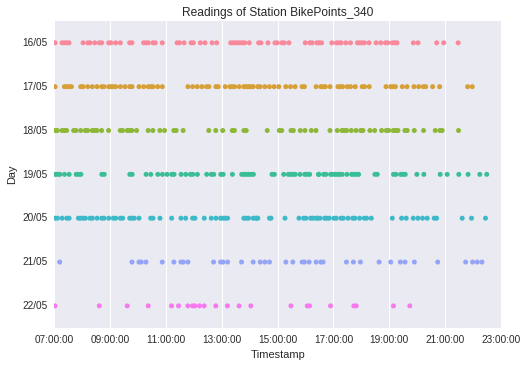

In [144]:
station_id = 'BikePoints_340'
plot_timeline(readings, station_id, start, end)

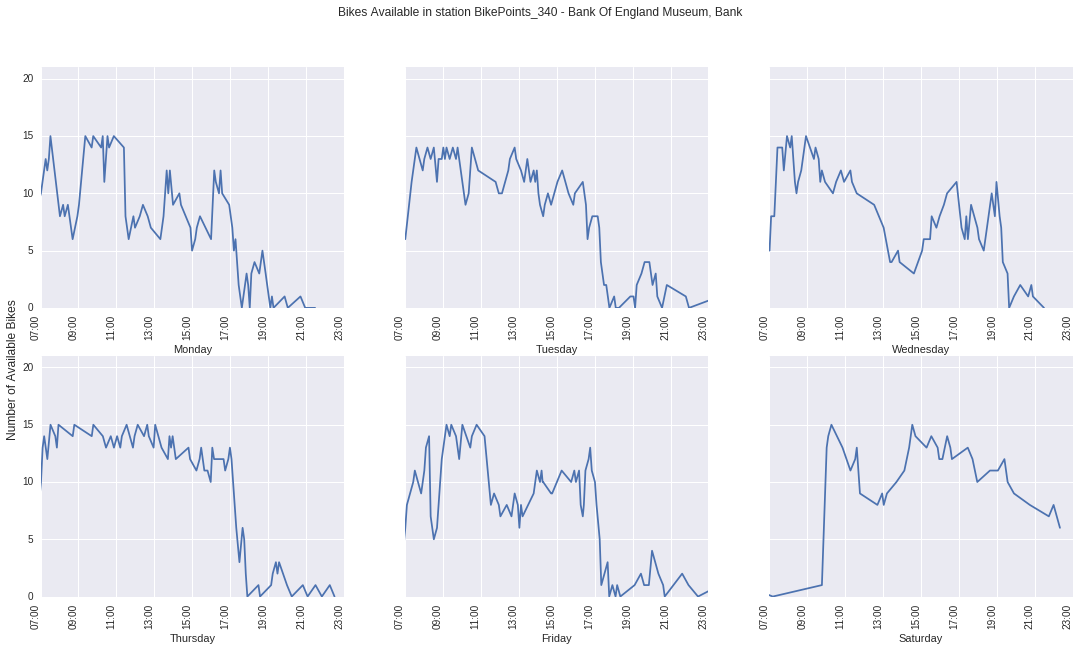

In [145]:
g = plot_station_readings(readings, station_id, ycols1, ycols2, start, end, 'BikePoints_340 - Bank Of England Museum, Bank')
plt.savefig('reports/images/individual-availability-center.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

**BikePoints_298 - Curlew Street, Shad Thames ** Outside City Center, located in Bermondsey

In [146]:
station_id = 'BikePoints_298'

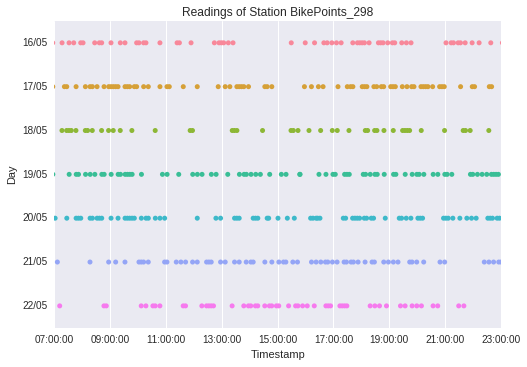

In [147]:
plot_timeline(readings, station_id, start, end)

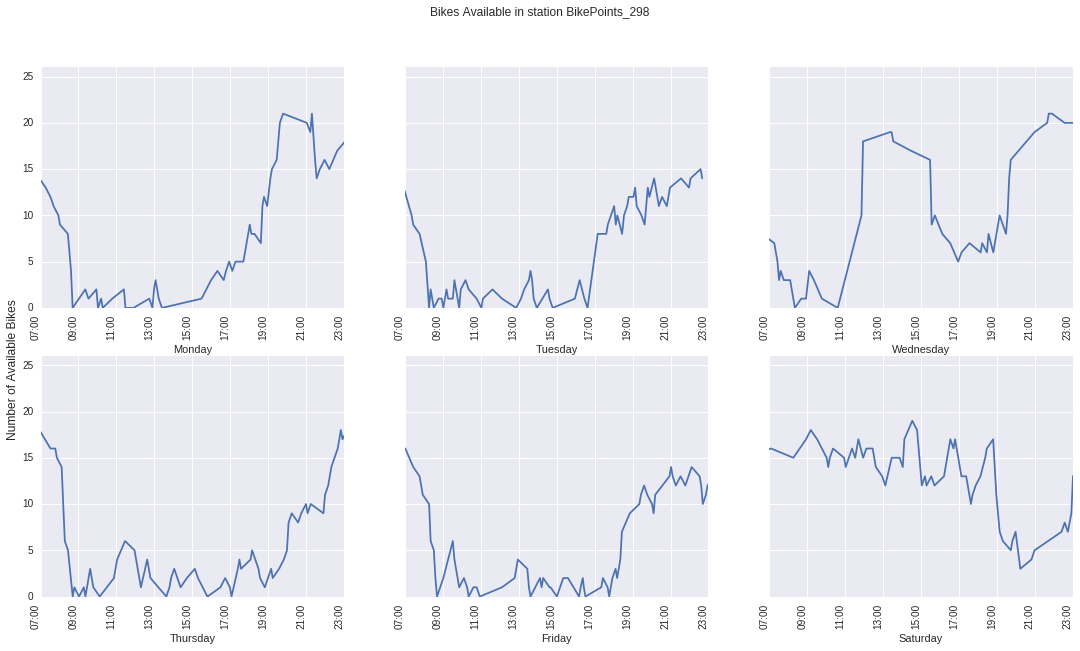

In [148]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)
plt.savefig('reports/images/individual-availability-outside.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

In [141]:
stations.sort_values(by=['Name']).to_csv('stations.csv')

In [18]:
distributed = distributed.reset_index()

## Bicycle Redistribution

In [19]:
print len(distributed)
print len(collected)
print len(distributed.Id.unique())
print len(collected.Id.unique())

39677
43396
768
756


In [20]:
distributed['Day'] = distributed.Timestamp.apply(lambda x: x.strftime('%d %m %Y'))
distributed.groupby('Day').mean().mean()

NbBikes    9.932787
dtype: float64

In [21]:
distributed = distributed.reset_index()
collected = collected.reset_index()
stations = stations.reset_index()

In [22]:
stations.Priority = stations.Priority.fillna(3).astype(int)

In [23]:
# merge with the stations dataset
stations_redistribution = stations.merge(distributed.groupby('Id').sum(), left_on='Id', how='left', right_index=True)
stations_redistribution.rename(columns = {'NbBikes':'NbBikesDist'}, inplace = True)
stations_redistribution = stations_redistribution.merge(collected.groupby('Id').sum(), left_on='Id', how='left', right_index=True)
stations_redistribution.rename(columns = {'NbBikes':'NbBikesColl'}, inplace = True)
stations_redistribution.drop(['TerminalName','PlaceType','Installed','Temporary','Locked','RemovalDate','InstallDate','ShortName'], axis=1, inplace=True)

# fill missing values with 0
stations_redistribution['NbBikesDist'].replace({0: 0.0001}, inplace=True)
stations_redistribution['NbBikesDist'].fillna(0.0001, inplace=True)
stations_redistribution['NbBikesColl'].replace({0: 0.0001}, inplace=True)
stations_redistribution['NbBikesColl'].fillna(0.0001, inplace=True)

# scale to use easily the colormap
min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
stations_redistribution['NbBikesDistS'] = min_max_scaler.fit_transform(stations_redistribution['NbBikesDist'].apply(np.log).values.reshape(-1, 1))
stations_redistribution['NbBikesCollS'] = min_max_scaler.fit_transform(stations_redistribution['NbBikesColl'].apply(np.log).values.reshape(-1, 1))

In [24]:
def plot_redistribution_grid(df, start, end, ids=None):
    df = df[df['Id'].isin(ids)]
    df = filter_by_time(df, start, end).copy()
    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    
    day_start, day_end = get_full_day_range(df.iloc[0]['Timestamp'])
    g = sns.FacetGrid(df, col="Id", col_wrap=4, size=3, xlim=(day_start, day_end), sharex=True, sharey=True, col_order=ids)
    [ax.xaxis_date() for ax in g.axes]
    [ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) for ax in g.axes]
    g = g.map(sns.stripplot, "Timestamp", "Day", "Day", orient='h', palette=sns.xkcd_palette(["windows blue"]))
    g = g.set(xticks=pd.date_range(start=day_start,end=day_end, freq='6h'))
    
    return g

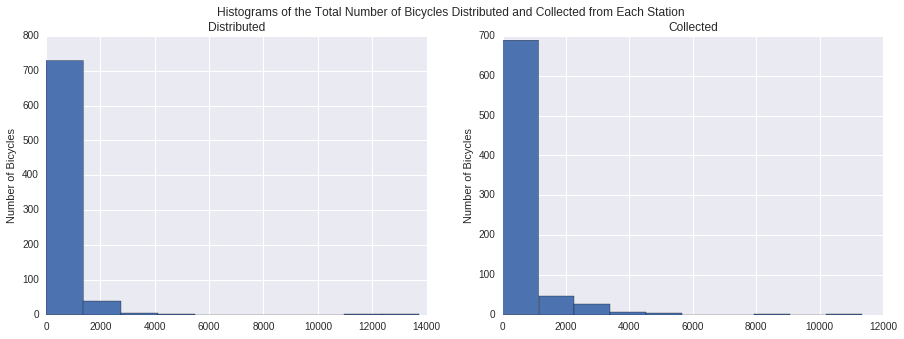

In [25]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Histograms of the Total Number of Bicycles Distributed and Collected from Each Station')

stations_redistribution['NbBikesDist'].hist(ax=axes[0])
stations_redistribution['NbBikesColl'].hist(ax=axes[1])

axes[0].set_title('Distributed')
axes[1].set_title('Collected')

axes[0].set_ylabel('Number of Bicycles')
axes[1].set_ylabel('Number of Bicycles')

plt.savefig('reports/images/bicycles-distributed-collected.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

### Distributed

In [26]:
top_distributed = stations_redistribution.sort_values(by=['NbBikesDist'], ascending=False)
top_distributed.set_index('Id', inplace=True)
top_distributed[0:20]

,level_0,index_x,Name,Latitude,Longitude,Priority,index_y,NbBikesDist,index,NbBikesColl,NbBikesDistS,NbBikesCollS
Id,,,,,,,,,,,,
BikePoints_374,293,293,"Waterloo Station 1, Waterloo",51.504027,-0.113864,1,18705933.0,13720.0,18514768.0,11324.0,1.000000,1.000000
BikePoints_361,280,280,"Waterloo Station 2, Waterloo",51.503919,-0.113426,1,14328975.0,11542.0,12275968.0,7939.0,0.990774,0.980850
BikePoints_20,110,110,"Drummond Street, Euston",51.527736,-0.135273,2,2207577.0,4246.0,1832787.0,2330.0,0.937403,0.914745
BikePoints_574,499,499,"Eagle Wharf Road, Hoxton",51.533560,-0.093150,2,8910450.0,3848.0,999891.0,211.0,0.932150,0.785235
BikePoints_154,61,61,"Waterloo Station 3, Waterloo",51.503791,-0.112824,1,937332.0,3778.0,827816.0,2568.0,0.931170,0.919989
BikePoints_436,352,352,"Red Lion Street, Holborn",51.518240,-0.116550,1,7492014.0,3390.0,10821538.0,3237.0,0.925387,0.932474
BikePoints_25,163,163,"Doric Way, Somers Town",51.528833,-0.132250,2,2800477.0,3216.0,2281365.0,1780.0,0.922575,0.900226
BikePoints_45,365,365,"Boston Place, Marylebone",51.522511,-0.162298,2,5843275.0,3041.0,4306647.0,1433.0,0.919588,0.888533
BikePoints_427,344,344,"Cheapside, Bank",51.513970,-0.092940,1,5993520.0,3020.0,7929618.0,3263.0,0.919219,0.932905


In [35]:
from palettable.colorbrewer.diverging import RdYlBu_10

def cmap_to_hex(cmap, value):
    rgb = cmap(value)[:3]
    return clrs.rgb2hex(rgb)

def create_redistribution_marker(col_name):
    def create_marker(station):
        line_color = map_priority_color(station['Priority'])[1]        

        fill_color = cmap_to_hex(plt.get_cmap('seismic_r'), station[col_name])
        
        label = "%s - %s" % (station.name, station['Name'])

        return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=100,
                        popup=label, color=fill_color, fill_color=fill_color, fill_opacity=0.9)
    
    return create_marker

In [36]:
distributed_map = draw_stations_map(top_distributed, create_redistribution_marker('NbBikesDistS'))
folium.TileLayer('stamentoner').add_to(distributed_map)
folium.Map.save(distributed_map, 'reports/maps/distributed_map.html')
distributed_map

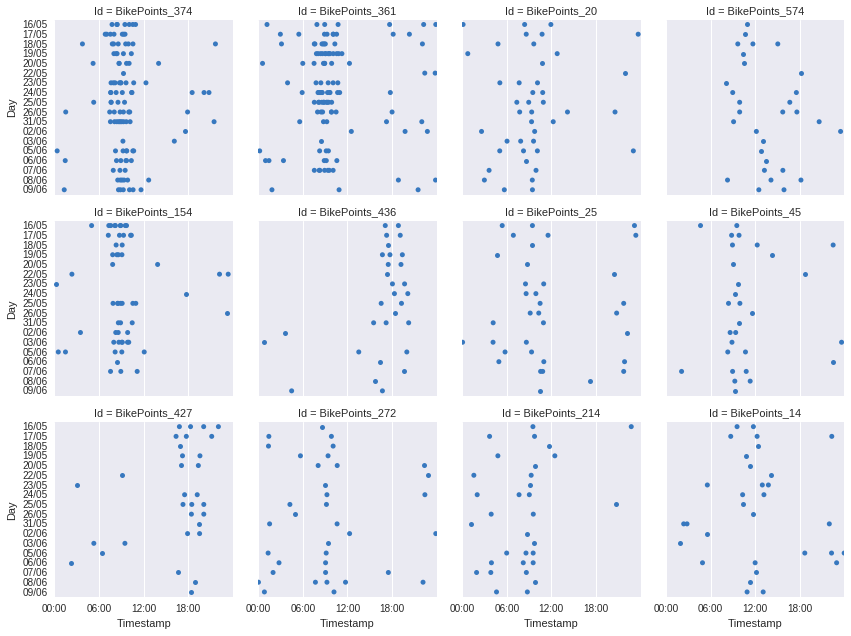

In [37]:
plot_redistribution_grid(distributed, datetime(2016,5,16), datetime(2016,6,10), ids=top_distributed.reset_index().Id[0:12])
plt.savefig('reports/images/bicycles-distributed.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

### Collected

In [38]:
top_collected = stations_redistribution.sort_values(by=['NbBikesColl'], ascending=False)
top_collected.set_index('Id', inplace=True)
top_collected[0:20]

,level_0,index_x,Name,Latitude,Longitude,Priority,index_y,NbBikesDist,index,NbBikesColl,NbBikesDistS,NbBikesCollS
Id,,,,,,,,,,,,
BikePoints_374,293,293,"Waterloo Station 1, Waterloo",51.504027,-0.113864,1,18705933.0,13720.0,18514768.0,11324.0,1.000000,1.000000
BikePoints_194,104,104,"Hop Exchange, The Borough",51.504627,-0.091773,1,52756.0,83.0,5091275.0,8859.0,0.727396,0.986762
BikePoints_361,280,280,"Waterloo Station 2, Waterloo",51.503919,-0.113426,1,14328975.0,11542.0,12275968.0,7939.0,0.990774,0.980850
BikePoints_228,140,140,"St. Jamess Square, St. Jamess",51.507424,-0.134621,1,924165.0,1081.0,5214238.0,5495.0,0.864387,0.961009
BikePoints_579,503,503,"Queen Street 2, Bank",51.511246,-0.093051,1,6603190.0,2259.0,15745827.0,5269.0,0.903723,0.958745
BikePoints_251,165,165,"Brushfield Street, Liverpool Street",51.518908,-0.079249,1,1212462.0,883.0,6043235.0,4760.0,0.853590,0.953266
BikePoints_64,569,569,"William Iv Street, Strand",51.509462,-0.124749,1,1032848.0,219.0,16651180.0,4634.0,0.779178,0.951820
BikePoints_278,193,193,"Tooley Street, Bermondsey",51.503493,-0.079620,1,462910.0,223.0,7713012.0,4136.0,0.780144,0.945689
BikePoints_108,10,10,"Abbey Orchard Street, Westminster",51.498125,-0.132102,1,123933.0,2253.0,273245.0,3975.0,0.903581,0.943548


In [39]:
collected_map = draw_stations_map(top_collected, create_redistribution_marker('NbBikesCollS'))
folium.TileLayer('stamentoner').add_to(collected_map)
folium.Map.save(collected_map, 'reports/maps/collected_map.html')
collected_map

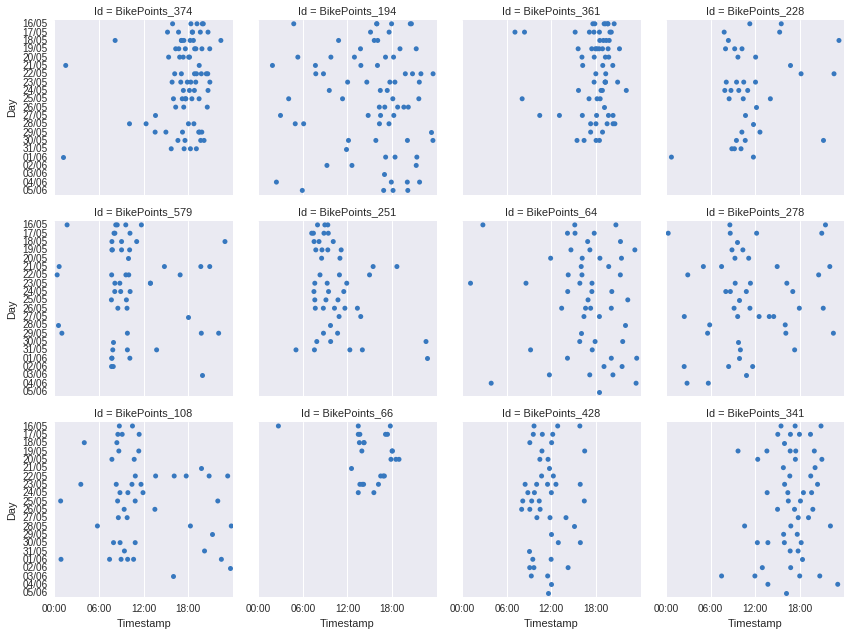

In [32]:
plot_redistribution_grid(collected, datetime(2016,5,16), datetime(2016,6,6), ids=top_collected.reset_index().Id[0:12])
plt.savefig('reports/images/bicycles-collected.eps', format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

### Clusters

In [83]:
%run src/data/periods.py

In [84]:
%run src/data/helper.py

In [87]:
readings2 = readings[readings.Source == 'REAL']
readings2 = readings2.sort_values(by=['Id', 'Timestamp'], ascending=True)

In [88]:
empty_entries = find_zero_periods(readings2, 'NbBikes')
empty_groups = get_ellapsed_time(empty_entries, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)
full_entries = find_zero_periods(readings2, 'NbEmptyDocks')
full_groups = get_ellapsed_time(full_entries, by='GroupId').sort_values(by=['Ellapsed'], ascending=False)

In [89]:
empty_all = empty_groups.groupby('Id').sum()
empty_all.columns=['EmptyTotalAll']

full_all = full_groups.groupby('Id').sum()
full_all.columns=['FullTotalAll']

In [90]:
invalid_threshold = 720
invalid_group_ids = empty_groups[empty_groups.Ellapsed >= invalid_threshold].GroupId
empty_entries = empty_entries[~empty_entries.GroupId.isin(invalid_group_ids)]
invalid_group_ids = full_groups[full_groups.Ellapsed >= invalid_threshold].GroupId
full_entries = full_entries[~full_entries.GroupId.isin(invalid_group_ids)]

In [91]:
empty_periods = get_ellapsed_time(empty_entries, by='PeriodId')
empty_periods = add_station_info(empty_periods, stations, ['Priority', 'Id'])
empty_periods['Day'] = empty_periods['Period'].apply(lambda x: get_period_day(x))
empty_periods['PeakHours'] = empty_periods['Period'].apply(lambda x: is_peaktime(x)[1])

full_periods = get_ellapsed_time(full_entries, by='PeriodId')
full_periods = add_station_info(full_periods, stations, ['Priority', 'Id'])
full_periods['Day'] = full_periods['Period'].apply(lambda x: get_period_day(x))
full_periods['PeakHours'] = full_periods['Period'].apply(lambda x: is_peaktime(x)[1])

In [92]:
empty_periods_df = empty_periods.groupby(['Id', 'PeakHours']).sum().unstack()
empty_periods_df.columns = empty_periods_df.columns.droplevel()
empty_periods_df.columns.name = None
empty_periods_df.columns = ['EmptyEveningPeak', 'EmptyMorningPeak', 'EmptyNonPeak']
empty_periods_df['EmptyTotal'] = empty_periods_df.EmptyEveningPeak + empty_periods_df.EmptyMorningPeak + empty_periods_df.EmptyNonPeak

In [93]:
full_periods_df = full_periods.groupby(['Id', 'PeakHours']).sum().unstack()
full_periods_df.columns = full_periods_df.columns.droplevel()
full_periods_df.columns.name = None
full_periods_df.columns = ['FullEveningPeak', 'FullMorningPeak', 'FullNonPeak']
full_periods_df['FullTotal'] = full_periods_df.FullEveningPeak + full_periods_df.FullMorningPeak + full_periods_df.FullNonPeak

In [94]:
periods = empty_periods_df.merge(full_periods_df, right_index=True, left_index=True)

In [95]:
readings2['WeightedNbBikesStd'] = readings.NbBikes / readings.NbDocks
weighted_std = readings2.groupby('Id').std()

In [97]:
stats = readings2.groupby('Id').agg({'Timestamp': 'count', 'NbDocks': 'max'})
stats.columns = ['Count', 'NbDocks']

stats = stats.merge(periods, how='left', right_index=True, left_index=True).fillna(0)
stats = stats.merge(top_collected[['NbBikesColl']], how='left', right_index=True, left_index=True).fillna(0)
stats = stats.merge(top_distributed[['NbBikesDist']], how='left', right_index=True, left_index=True).fillna(0)
stats = stats.merge(weighted_std[['WeightedNbBikesStd']], how='left', right_index=True, left_index=True).fillna(0)

stats = add_station_info(stats, stations.set_index(stations.Id), use_indexes=True).drop(['Id', 'Name'], axis=1)
stats.Priority = stats.Priority.fillna(3).astype('int8')
stats

,Count,NbDocks,EmptyEveningPeak,EmptyMorningPeak,EmptyNonPeak,EmptyTotal,FullEveningPeak,FullMorningPeak,FullNonPeak,FullTotal,NbBikesColl,NbBikesDist,WeightedNbBikesStd,Latitude,Longitude,Priority
Id,,,,,,,,,,,,,,,,
BikePoints_1,1348,19.0,716.0,1289.0,3600.0,5605.0,118.0,5.0,977.0,1100.0,9.0,1121.0,0.249440,51.529163,-0.109970,2
BikePoints_10,1750,18.0,455.0,457.0,4055.0,4967.0,167.0,0.0,797.0,0.0,341.0,125.0,0.276474,51.505974,-0.092754,2
BikePoints_100,1956,24.0,290.0,36.0,910.0,1236.0,26.0,437.0,645.0,1108.0,257.0,450.0,0.240004,51.490435,-0.122806,2
BikePoints_101,3244,22.0,788.0,878.0,15559.0,17225.0,183.0,890.0,1035.0,2108.0,0.0,0.0,0.296015,51.511553,-0.092940,1
BikePoints_102,1712,17.0,1761.0,897.0,16005.0,18663.0,270.0,729.0,3105.0,4104.0,351.0,150.0,0.334019,51.513406,-0.076793,2
BikePoints_103,1340,18.0,753.0,1721.0,4788.0,7262.0,5.0,135.0,105.0,245.0,26.0,516.0,0.237761,51.504723,-0.192538,2
BikePoints_104,3014,34.0,155.0,1119.0,4281.0,5555.0,273.0,66.0,732.0,1071.0,2119.0,201.0,0.290370,51.511594,-0.077121,1
BikePoints_105,2168,26.0,694.0,166.0,1535.0,2395.0,17.0,440.0,3265.0,3722.0,78.0,340.0,0.273838,51.515529,-0.190240,2
BikePoints_106,1510,21.0,751.0,2028.0,19186.0,21965.0,130.0,21.0,1153.0,1304.0,142.0,196.0,0.296680,51.514105,-0.147301,2


In [101]:
stats.sort_values(by=['Count'], ascending=False)

,Count,NbDocks,EmptyEveningPeak,EmptyMorningPeak,EmptyNonPeak,EmptyTotal,FullEveningPeak,FullMorningPeak,FullNonPeak,FullTotal,NbBikesColl,NbBikesDist,WeightedNbBikesStd,Latitude,Longitude,Priority
Id,,,,,,,,,,,,,,,,
BikePoints_14,4750,48.0,30.0,632.0,892.0,1554.0,99.0,9.0,1466.0,1574.0,2523.0,2520.0,0.237829,51.529943,-0.123616,1
BikePoints_194,4585,56.0,0.0,41.0,1976.0,0.0,371.0,53.0,1359.0,1783.0,8859.0,83.0,0.269856,51.504627,-0.091773,1
BikePoints_132,4203,38.0,79.0,595.0,4795.0,5469.0,228.0,0.0,467.0,0.0,1149.0,963.0,0.270609,51.523648,-0.074754,1
BikePoints_191,4194,28.0,977.0,257.0,9278.0,10512.0,336.0,312.0,999.0,1647.0,462.0,414.0,0.248440,51.503117,-0.153520,1
BikePoints_39,4191,41.0,75.0,654.0,3949.0,4678.0,0.0,0.0,15.0,0.0,1092.0,864.0,0.245162,51.526377,-0.078130,1
BikePoints_251,4183,34.0,460.0,10.0,11606.0,12076.0,15.0,436.0,680.0,1131.0,4760.0,883.0,0.289847,51.518908,-0.079249,1
BikePoints_341,4091,23.0,75.0,525.0,4373.0,4973.0,1042.0,20.0,2401.0,3463.0,3552.0,1664.0,0.281550,51.508103,-0.126021,1
BikePoints_553,4064,24.0,300.0,1388.0,2368.0,4056.0,525.0,72.0,6403.0,7000.0,923.0,1589.0,0.298380,51.535678,-0.062546,1
BikePoints_73,4012,37.0,314.0,332.0,8377.0,9023.0,46.0,0.0,100.0,0.0,1396.0,251.0,0.230097,51.525726,-0.088486,1


In [ ]:
pickle.dump(stats, open("data/parsed/stations_statistics.p", "wb"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

empty_pred = KMeans(n_clusters=3).fit_predict(stats[['EmptyEveningPeak', 'EmptyMorningPeak', 'EmptyNonPeak']].values)
full_pred = KMeans(n_clusters=3).fit_predict(stats[['FullEveningPeak', 'FullMorningPeak', 'FullNonPeak']].values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.5))

###############################################################################
# Empty Minutes Clusters

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_title('Empty Minutes Clusters')
ax.set_xlabel('EmptyEveningPeak')
ax.set_ylabel('EmptyMorningPeak')
ax.set_zlabel('EmptyNonPeak')

ax.set_xlim(0, max(stats.EmptyEveningPeak))
ax.set_ylim(0, max(stats.EmptyMorningPeak))
ax.set_zlim(0, max(stats.EmptyNonPeak))

ax.view_init(elev=30, azim=230)
ax.dist=12                  

ax.scatter(stats.EmptyEveningPeak, stats.EmptyMorningPeak, stats.EmptyNonPeak,
           c=empty_pred, color='red', marker='o', s=30)

###############################################################################
# Full Minutes Clusters

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_title('Full Minutes Clusters')
ax.set_xlabel('FullEveningPeak')
ax.set_ylabel('FullMorningPeak')
ax.set_zlabel('FullNonPeak')

ax.set_xlim(0, max(stats.FullEveningPeak))
ax.set_ylim(0, max(stats.FullMorningPeak))
ax.set_zlim(0, max(stats.FullNonPeak))

ax.view_init(elev=30, azim=230)
ax.dist=12                  

ax.scatter(stats.FullEveningPeak, stats.FullMorningPeak, stats.FullNonPeak,
           c=full_pred, color='blue', marker='o', s=30)

plt.show()

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.scatter(stats.Count, stats.NbDocks, c=stats.Priority)
plt.title("Incorrect Number of Blobs")

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

###############################################################################
# Generate sample data
X = stats[['Count', 'NbDocks']].values

###############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

###############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
chido = stats.copy()
chido['EmptyCluster'] = empty_pred
chido['FullCluster'] = full_pred
chido['ActivityCluster'] = ms.labels_

In [ ]:
chido